In [ ]:
#creating a reverse search engine on cars using pre trained deep learning model (ResNet50)
#For model data we are collecting data from stanford cars training dataset.
#datset url: "https://ai.stanford.edu/~jkrause/cars/car_dataset.html#:~:text=The%20Cars%20dataset%20contains%2016%2C185,or%202012%20BMW%20M3%20coupe."
#we are limitting our data to 150 samples from the data as model is pre trained and there is no need to retrain the model.
#"cars_train" folder had all the  images.
#"cars_new" folder had the sampled images.

In [1]:
#importing opencv and matplotlib Libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Assigning the dataset path.
import os,os.path
#As i was trained the model in my machine " mac_book_air_2017" the path needs to be changed when working on other machine.
path="/Users/lazyhacker/Desktop/reverse_image_generator/cars_new"

In [12]:
#importing Libraries needed to run the deep learning model.
import numpy as np
import tensorflow as tf
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
import time

In [7]:
#importing pretrainded "ResNet50" deep learning model.
"""
The reason we are not using "InceptionV3" pretrained model is 
the features before and after polling in "ResNet50" are same 2048 
where as in  "InceptionV3" its 51200 features before pooling and 2048 after pooling
which may leads to low_variance explained.
"""
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [8]:
deep_learning_model = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
def features(path, model):
    input_shape = (224, 224, 3)
    image_m = image.load_img(path, target_size=(
        input_shape[0], input_shape[1]))
    image_array = image.img_to_array(image_m)
    exp_array = np.expand_dims(image_array, axis=0)
    processed_image = preprocess_input(exp_array)
    pre_features = model.predict(processed_image)
    final_features = pre_features.flatten()
    normalized_features = final_features / norm(final_features)
    return normalized_features

In [9]:
#Assigning extensions is just a simple preprocessing over images format. As our data conatains "jpg" format images , we are limiting to that.
extensions = ['.jpg']
#getting files.
def f_list(i_dir):
    f_list = []
    i = 1
    for root, directories, filenames in os.walk(i_dir):
        for filename in filenames:
            if any(img in filename for img in extensions):
                f_list.append(os.path.join(root, filename))
                i += 1
    return f_list

In [10]:
#Uploading the images from dataset.
images_data = sorted(f_list(path))

In [15]:
f_list = []
for i in tqdm_notebook(range(len(images_data))):
    f_list.append(features(images_data[i], deep_learning_model)) # appending the features into the list.



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [24]:
#https://scikit-learn.org/stable/modules/neighbors.html
from sklearn.neighbors import NearestNeighbors  # Using sklearn NearestNeighbors model to find nearest images based in their feature vector.
neighbors = NearestNeighbors(n_neighbors=5, algorithm='auto', 
metric='euclidean').fit(f_list)

In [17]:
sample_image=cv2.imread("01395.jpg") # Taking sample image for model testing.

Query  Image


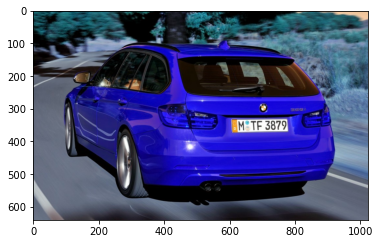

In [20]:
print("Query  Image")
plt.imshow(sample_image)

Similar images generated by model
Images :
00046.jpg
00062.jpg
00117.jpg
00085.jpg
00082.jpg


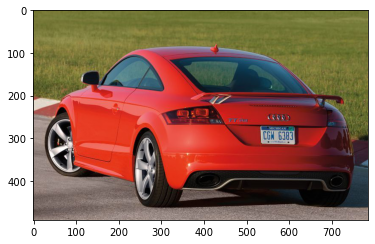

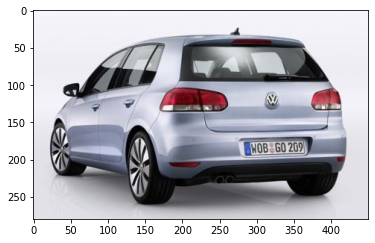

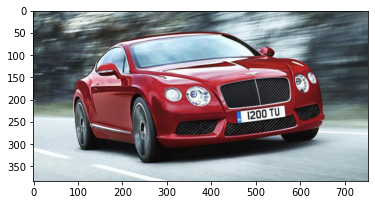

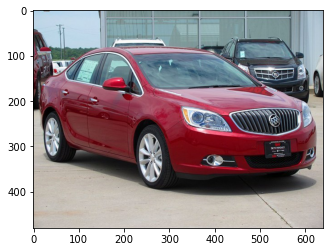

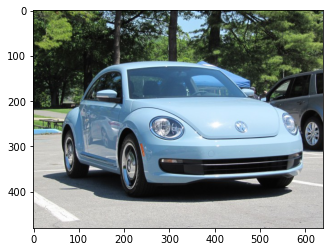

In [29]:
import matplotlib.image as mpimg
print("Similar images generated by model")
print("Images :")
query=features("01395.jpg",deep_learning_model)
distances, indices = neighbors.kneighbors([query])
def printimg(img):
    image = mpimg.imread(img)
    plt.figure()
    plt.imshow(image)
    print(os.path.basename(img))
for index in indices:
    for img in index:
        printimg(images_data[img])

In [34]:
#Comparing the similarity using ORB (Oriented FAST and Rotated BRIEF) 
# Between our Query image and images  generated by the model.
 #The function "generate_descriptor" generate the feature vector(descriptor) for the image.
def generate_descriptor(img):
    img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2HSV)
    orb = cv2.ORB_create()
    queryKeypoints, queryDescriptors = orb.detectAndCompute(img,None)
    return queryKeypoints,queryDescriptors

In [35]:
q_img1=cv2.imread("01395.jpg") #Query image.
q_img2=cv2.imread("/Users/lazyhacker/Desktop/reverse_image_generator/cars_new/00062.jpg")  #One of the similar images generated by the model.

#Getting orb descriptor and orb key points values for both the images.
orb1k,orb1d=generate_descriptor(q_img1)
orb2k,orb2d=generate_descriptor(q_img2)

In [36]:
#Intializing a bf matcher and getting the feacture matches.
bf = cv2.BFMatcher()
matches = bf.knnMatch(orb1,orb2, k=2)

In [37]:
#Getting genuine matches baseb upon the distance between them.
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

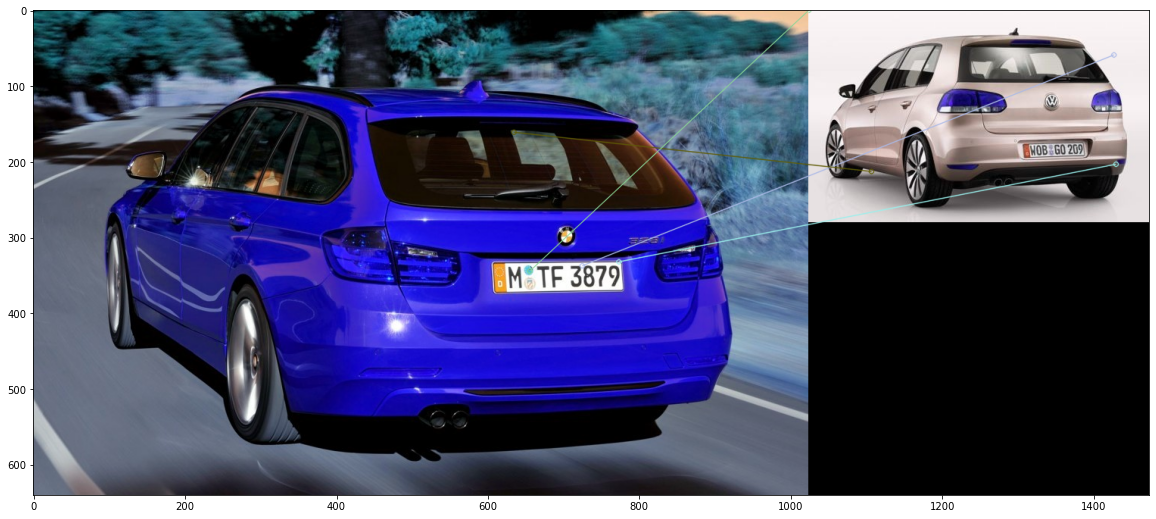

In [45]:
#Plotting the matches.
matching = cv2.drawMatchesKnn(q_img1,orb1k,q_img2,orb2k,good,None,flags=2)
plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(matching)

plt.show()

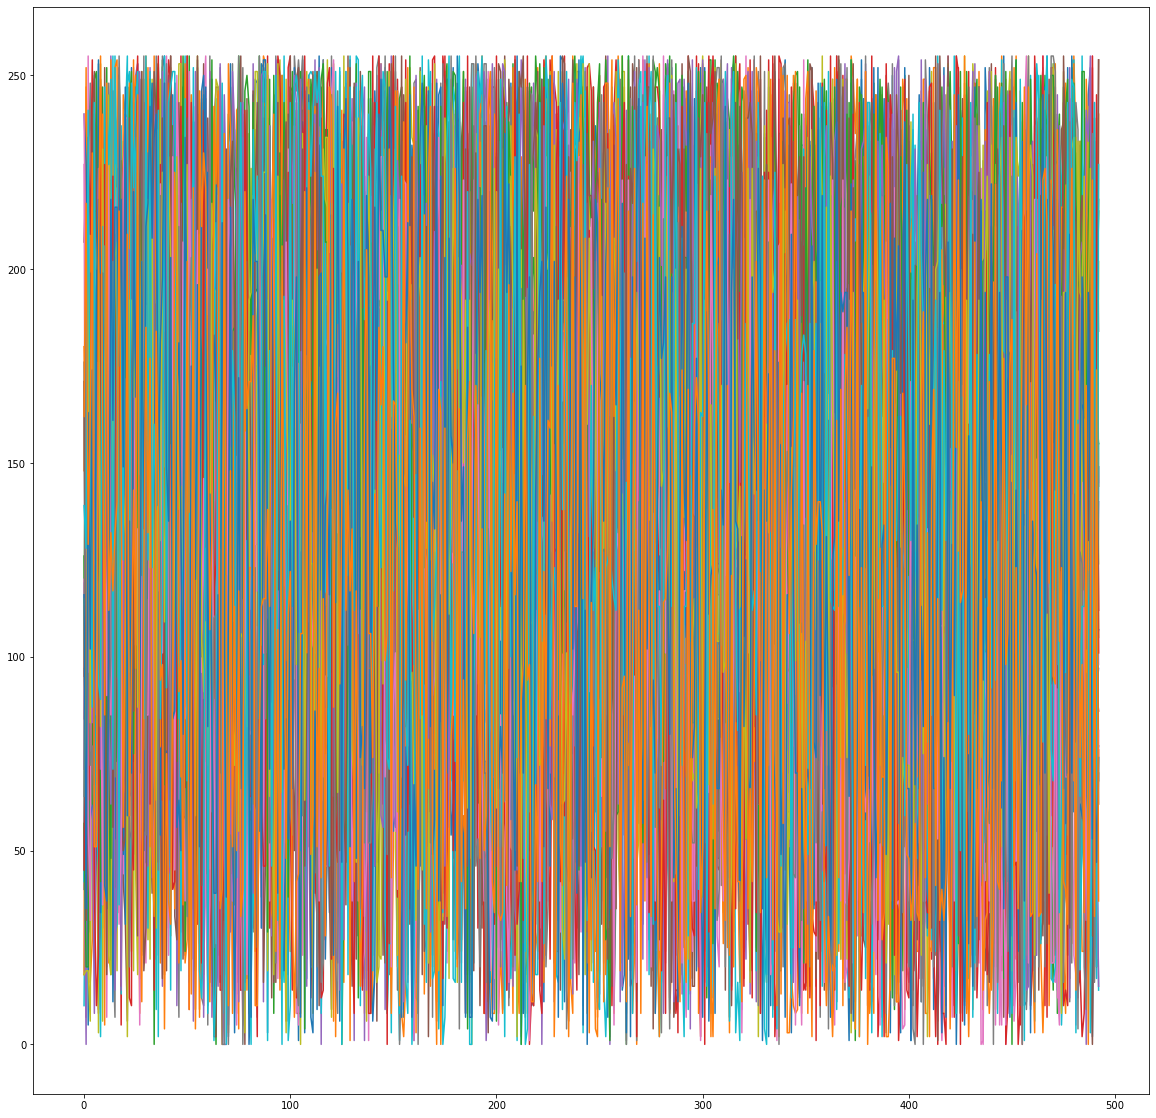

In [54]:
#Plotting the descriptors
plt.plot(orb1d)

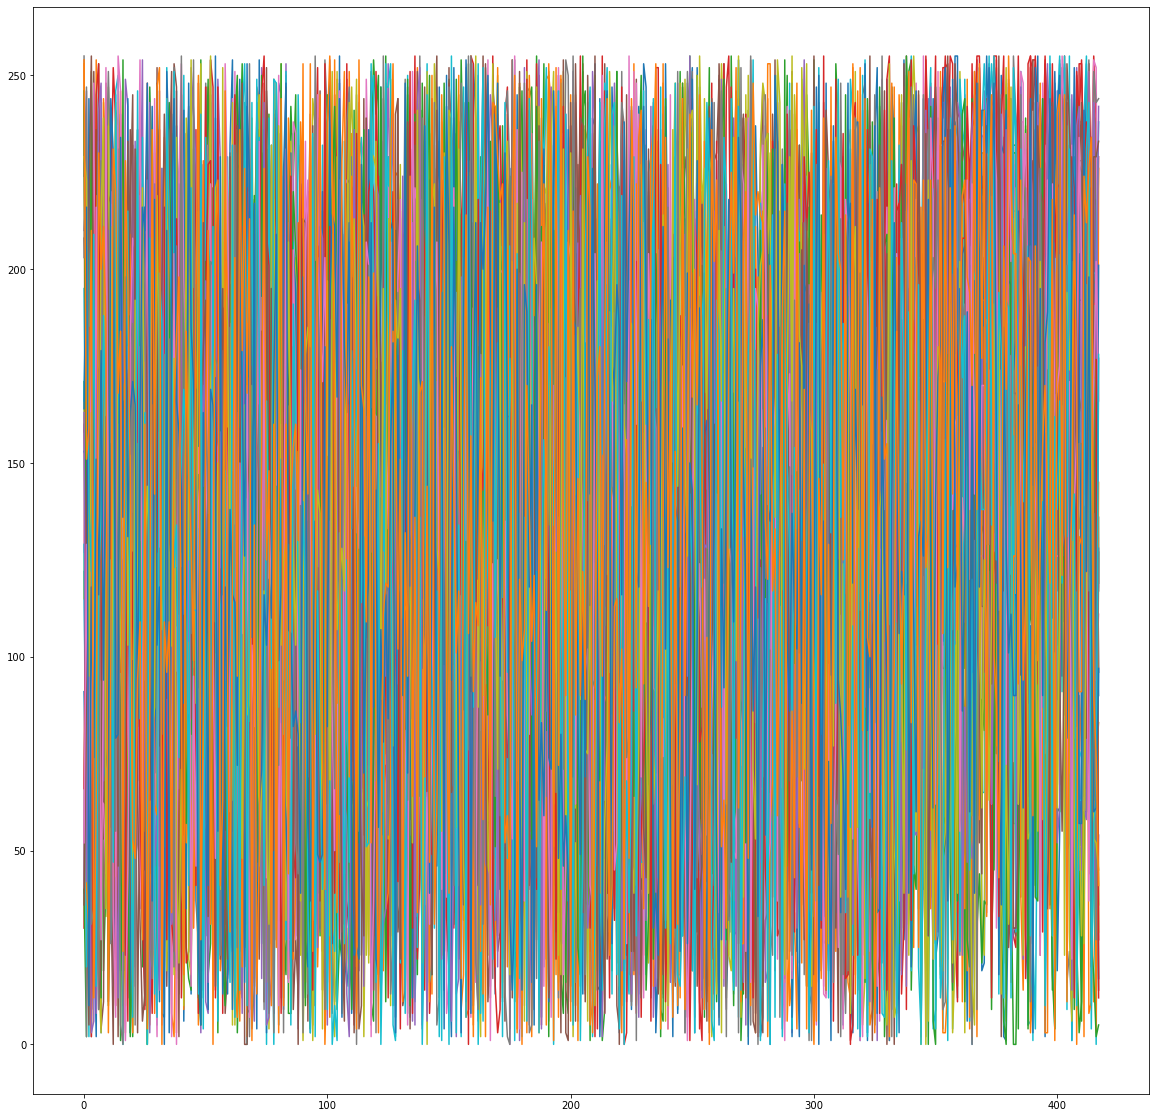

In [52]:
plt.plot(orb2d)